In [98]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import Callback, EarlyStopping
from keras.utils import to_categorical, load_img, img_to_array
from sklearn.metrics import confusion_matrix
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
os.listdir("dataset1/")

['readme.txt', 'known_images', 'unknown_images']

Load all the images

In [100]:
def load_images():
    images_dir = Path('dataset1/known_images/')
    normal_images = images_dir.glob('normal*.png')
    sick_images = images_dir.glob('sick*.png')
    img_data = []
    label_data = []
    for img in normal_images:
        img_data.append(img)
        label_data.append('normal')
    for img in sick_images:
        img_data.append(img)
        label_data.append('sick')
    df = pd.DataFrame(img_data)
    df.columns = ['images']
    df['labels'] = label_data
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [101]:
df_known_images = load_images()

df_known_images

,images,labels
0,dataset1\known_images\normal_309.png,normal
1,dataset1\known_images\normal_350.png,normal
2,dataset1\known_images\sick_40.png,sick
3,dataset1\known_images\sick_223.png,sick
4,dataset1\known_images\normal_236.png,normal
...,...,...
710,dataset1\known_images\normal_161.png,normal
711,dataset1\known_images\normal_13.png,normal
712,dataset1\known_images\sick_333.png,sick
713,dataset1\known_images\sick_1.png,sick


In [102]:
df_known_images.shape

(715, 2)

We now check if the data is balanced

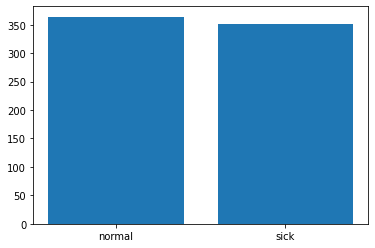

In [103]:
plt.bar(df_known_images['labels'].value_counts().index, df_known_images['labels'].value_counts().values)
plt.show()

Visualise some of the images

In [104]:
def visualise_images(images, labels):
    plt.figure(figsize=(10,5))
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        img = cv2.imread(str(images[i]))
        img = cv2.resize(img, (224, 224))
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis('off')

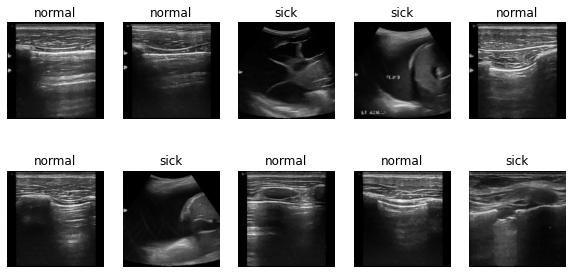

In [105]:
visualise_images(df_known_images['images'], df_known_images['labels'])

Split the data into Test and Training

In [106]:
def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.2, test_split=0.0):
    assert (train_split + test_split + val_split) == 1
    
    # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(train_split * len(df)), int((1 - val_split - test_split) * len(df))]
    
    train_ds, test_ds, val_ds = np.split(df_sample, indices_or_sections)
    
    return train_ds, val_ds, test_ds

In [107]:
train_ds, val_ds, test_ds = get_dataset_partitions_pd(df_known_images)


Check if the training data is balanced

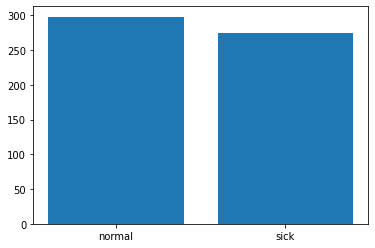

In [108]:
plt.bar(train_ds['labels'].value_counts().index, train_ds['labels'].value_counts().values)
plt.show()

Prepare the Validation Dataset, by processing the images through resizing and changing color scale to RGB

In [109]:
def prepare_dataset(images):
    if 'normal' in images['labels'].values:
        normal_cases = images
    if 'sick' in images['labels'].values:
        sick_cases = images
    data, labels = ([] for x in range(2))
    def prepare(case):
        for img in case['images']:
            img = cv2.imread(str(img))
            img = cv2.resize(img,(224,224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            if 'normal' in case['labels'].values:
                label = to_categorical(0 , num_classes=2)
            else:
                label = to_categorical(1 , num_classes=2)
            data.append(img)
            labels.append(label)
        return data, labels
    prepare(normal_cases)
    d,l = prepare(sick_cases)
    d = np.array(d)
    l = np.array(l)
    return d,l



In [110]:
val_data, val_labels = prepare_dataset(val_ds)
print(val_data)
#visualise_images(val_data,val_labels)

[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0. 

We’ll now write a function to generate images in batches from the train set.

In [111]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size

    # define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32) 
    batch_labels = np.zeros((batch_size, 2), dtype=np.float32)

    # get a numpy array of all the indices of the input data
    indices = np.arange(n) 

    # initialize a counter
    i = 0
    while True:
        np.random.shuffle(indices)
        # Get the next batch
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            if label=='normal':
                label=0
            else:
                label=1
            #one hot encoding
            encoded_label = to_categorical(label, num_classes=2)

            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224, 224))

            # check if it's grayscale
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.

            batch_data[count] = orig_img
            batch_labels[count] = encoded_label

            count+=1

            if count==batch_size-1:
                break
        
        i+=1
        yield batch_data, batch_labels

        if i>=steps:
            i=0



In [112]:
# Testing the data generation function
data_gen(train_ds, 160)

<generator object data_gen at 0x000001C571854740>

We now build the Deep Learning CNN Model for prediction

In [113]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape = (224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))


A ReLu activation is applied after every convolution to transform the output values between the range 0 to 1. Max pooling is used to downsample the input representation. It helps the model to deal with overfitting by providing an abstract representation and also reduces the computational cost. 

In [114]:
batch_size = 16
nb_epochs = 3

# Fetch the training data from the generator
train_data_gen = data_gen(data=train_ds, batch_size=batch_size)

# define number of training steps
nb_train_steps =  train_ds.shape[0]//batch_size

print(train_ds.shape)

print(train_data_gen)

print("Number of training and validation steps: {} and {} ".format(nb_train_steps, len(val_ds)))

(572, 2)
<generator object data_gen at 0x000001C58BBBA960>
Number of training and validation steps: 35 and 143 


Batch size refers to the number of images fed to the network in a single forward pass. On the other hand, the number of epochs determines the number of times our network would process the whole training data. The number of training steps is the number of steps in one epoch and is calculated by dividing the size of our training data by the batch size. 

We’ll use binary cross-entropy as our loss function because we have only 2 classes. Rmsprop will be our optimizer function. Let’s start training.

In [115]:
model.compile(loss='binary_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])

# Fit the model
history = model.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(val_data,val_labels))

Epoch 1/3
35/35 [==============================] - 14s 385ms/step - loss: 0.5117 - accuracy: 0.7161 - val_loss: 2.7242 - val_accuracy: 0.2657
Epoch 2/3
35/35 [==============================] - 16s 465ms/step - loss: 0.2394 - accuracy: 0.8696 - val_loss: 2.8883 - val_accuracy: 0.4895
Epoch 3/3
35/35 [==============================] - 16s 472ms/step - loss: 0.1303 - accuracy: 0.9268 - val_loss: 3.0286 - val_accuracy: 0.4476


It is quite evident that our validation accuracy is not that good. <br>There are a number of tricks that you can use to get good performance.
<ul>
<li>Change the batch size.</li>
<li>Train for more epochs.</li>
<li>Use a different optimizer.</li> 
<li>Tweak the neural network by adding/ removing layers.</li>
</ul>
<br>
The list can really go on. The important thing to note here is that trying out all these things is time-consuming and it may or may not work.

So, what’s the alternative?

**Transfer Learning** <br>
Training a neural network from scratch can require a lot of data, processing power, and time which can be unavailable or impractical most times. Transfer learning is a technique of using pre-trained neural networks that are trained on billions of images( like Alexnet, Inception net, VGG16)  on a different task by changing the last classification layer. Now, you might be thinking what’s the benefit and how this works? Like I have mentioned above, the initial layers learn very general features and as we go higher up in the network, the layers tend to learn patterns more specific to the task it is being trained on. Since the pre-trained models are trained on a huge number of images they can do a better job at learning these abstract features than the neural network written from scratch.

We will use pre-trained VGG16 

In [116]:
def vgg16_model(num_of_classes = None):
    model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

    x=Dense(1024, activation='relu')(model.layers[-4].output)
    x=Dropout(0.7)(x)
    x=Dense(512, activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(2, activation='softmax')(x)
    model=Model(model.input, x)

    return model

In [117]:
vgg_conv = vgg16_model(2)
for layer in vgg_conv.layers[:-10]:
    layer.trainable = False

In [118]:
opt =  Adam(learning_rate=0.0001, decay=1e-5)
vgg_conv.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

In [119]:
# Fit the model
history = vgg_conv.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(val_data,val_labels),
                        class_weight={0:1.0, 1:0.4})

Epoch 1/3
35/35 [==============================] - 140s 4s/step - loss: 0.3433 - accuracy: 0.7018 - val_loss: 1.3228 - val_accuracy: 0.5734
Epoch 2/3
35/35 [==============================] - 143s 4s/step - loss: 0.1046 - accuracy: 0.9036 - val_loss: 3.1186 - val_accuracy: 0.4755
Epoch 3/3
35/35 [==============================] - 144s 4s/step - loss: 0.0725 - accuracy: 0.9411 - val_loss: 5.4077 - val_accuracy: 0.4685
